          Date  Stock Price  Call Price  Put Price  Portfolio Delta  \
0   2025-01-01       171.63       16.85       8.06           101.39   
1   2025-01-02       171.20       16.58       8.16           101.35   
2   2025-01-03       173.34       17.73       7.58           101.53   
3   2025-01-06       178.42       20.62       6.32           101.94   
4   2025-01-07       177.66       20.12       6.48           101.88   
5   2025-01-08       176.90       19.63       6.64           101.82   
6   2025-01-09       182.28       22.93       5.47           102.23   
7   2025-01-10       184.97       24.65       4.95           102.42   
8   2025-01-13       183.36       23.48       5.21           102.31   
9   2025-01-14       185.28       24.71       4.85           102.45   
10  2025-01-15       183.69       23.62       5.13           102.33   
11  2025-01-16       182.10       22.56       5.42           102.22   
12  2025-01-17       182.96       23.07       5.24           102.28   
13  20

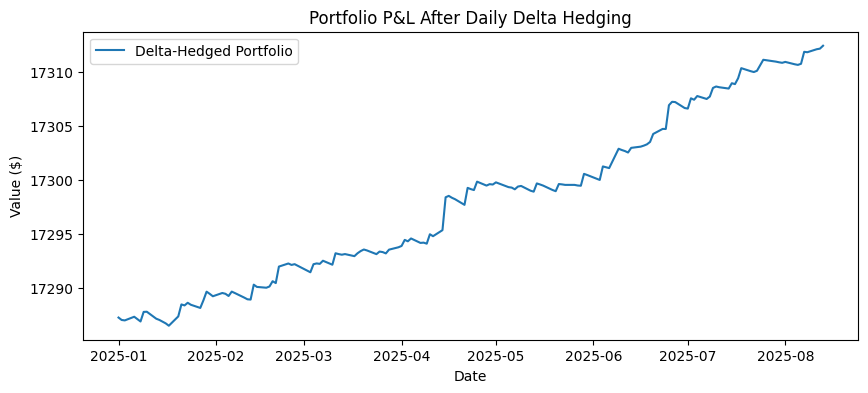

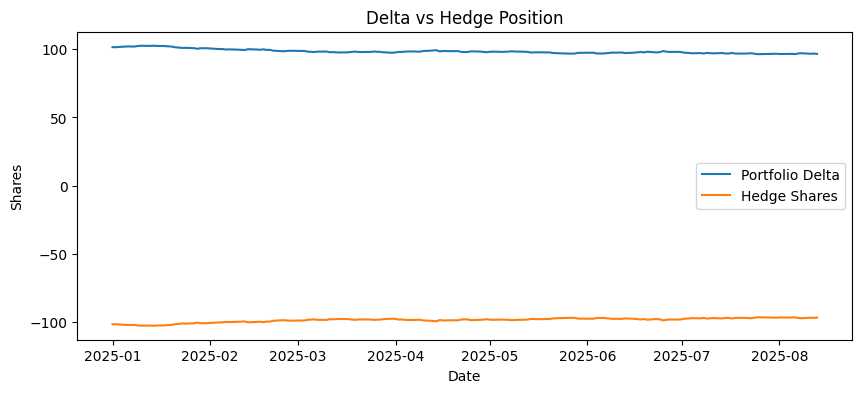

In [1]:
# === Portfolio Delta Hedging (Beginner-Friendly) ===
# Goal: Show how stock + options portfolio value changes and
#       how delta hedging works step by step.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# ---- Step 1: Black-Scholes pricing and delta ----
def bs_price(S, K, T, r, sigma, option_type='call'):
    """Black-Scholes option price"""
    if T <= 0:  # option expired
        return max(S-K, 0) if option_type == 'call' else max(K-S, 0)
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if option_type == 'call':
        return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else:
        return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

def bs_delta(S, K, T, r, sigma, option_type='call'):
    """Black-Scholes option delta"""
    if T <= 0:
        return 0
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    return norm.cdf(d1) if option_type == 'call' else norm.cdf(d1) - 1

# ---- Step 2: Define portfolio ----
portfolio = {
    'stock': {'qty': 100},  # long 100 shares
    'call':  {'type': 'call', 'K': 180, 'expiry': '2025-12-20', 'qty': 5},
    'put':   {'type': 'put',  'K': 160, 'expiry': '2025-12-20', 'qty': 5}
}

r, sigma = 0.05, 0.25  # interest rate and volatility

# ---- Step 3: Simulate stock prices ----
dates = pd.date_range('2025-01-01', '2025-08-13', freq='B')
np.random.seed(42)
S0, vol = 170, 0.3
rets = np.random.normal((0.08 - 0.5*vol**2)/252, vol/np.sqrt(252), len(dates))
prices = S0 * np.exp(np.cumsum(rets))  # geometric Brownian motion
px = pd.Series(prices, index=dates)

# ---- Step 4: Simulation of hedging ----
results = []
cash, hedge = 0, 0  # initial hedge and cash

for date, S in px.items():
    # Stock position
    value = portfolio['stock']['qty'] * S
    delta = portfolio['stock']['qty']

    # Options positions
    for opt in ['call', 'put']:
        expiry = pd.to_datetime(portfolio[opt]['expiry'])
        T = max((expiry - date).days / 365, 0)
        K, qty, opt_type = portfolio[opt]['K'], portfolio[opt]['qty'], portfolio[opt]['type']

        price = bs_price(S, K, T, r, sigma, opt_type)
        dlt   = bs_delta(S, K, T, r, sigma, opt_type)

        value += qty * price
        delta += qty * dlt

        if opt == 'call': call_price = price
        if opt == 'put':  put_price  = price

    # Hedge trade (neutralize delta)
    trade = -delta - hedge
    cash -= trade * S
    hedge += trade

    total = value + hedge*S + cash

    # Save daily results
    results.append({
        'Date': date.date(),
        'Stock Price': S,
        'Call Price': call_price,
        'Put Price': put_price,
        'Portfolio Delta': delta,
        'Hedge Shares': hedge,
        'Cash': cash,
        'Total Value': total
    })

# ---- Step 5: Put results into DataFrame ----
df = pd.DataFrame(results)
pd.set_option('display.float_format', '{:.2f}'.format)
print(df.head(15))  # show first 15 rows

# ---- Step 6: Plot results ----
plt.figure(figsize=(10,4))
plt.plot(dates, df['Total Value'], label='Delta-Hedged Portfolio')
plt.title('Portfolio P&L After Daily Delta Hedging')
plt.xlabel('Date'); plt.ylabel('Value ($)'); plt.legend(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(dates, df['Portfolio Delta'], label='Portfolio Delta')
plt.plot(dates, df['Hedge Shares'], label='Hedge Shares')
plt.title('Delta vs Hedge Position')
plt.xlabel('Date'); plt.ylabel('Shares'); plt.legend(); plt.show()
